In [2]:
# Importing essentials libraries

from keras.layers import *
from keras.models import Sequential, Model
from keras import optimizers
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import callbacks

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix,classification_report

from PIL import Image
import numpy as np
import random
import pandas as pd
import os
import cv2

In [3]:
# Loading MNIST Dataset
# Dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.

# uint8 array of grayscale image data with shape (60000, 785).
#1 column for the label and rest 784 = 28 x28 
train = pd.read_csv('../Dataset/MNIST/mnist_train.csv')

# uint8 array of grayscale image data with shape (10000, 785).
#1 column for the label and rest 784 = 28 x28 
test = pd.read_csv('../Dataset/MNIST/mnist_test.csv')

In [4]:
# Creating Training data
x_train = train.drop(['label'],1).values
y = train['label'].values

In [5]:
# Creating Test data
x_test = test.drop(['label'],1).values
y_test = test['label'].values

In [6]:
# Encodeing labels to one hot vector
# ex : 2 => [0,0,1,0,0,0,0,0,0,0]

y = to_categorical(y)
y_test = to_categorical(y_test)

In [7]:
# Function to add Gaussian Noise

def gaussian_noise(image, sigma):
    img = np.array(image)
    noise = np.random.randn(img.shape[0], img.shape[1])
    img = img.astype('int16')
    img_noise = img + noise * sigma
    img_noise = np.clip(img_noise, 0, 255)
    img_noise = img_noise.astype('uint8')
    return Image.fromarray(img_noise)

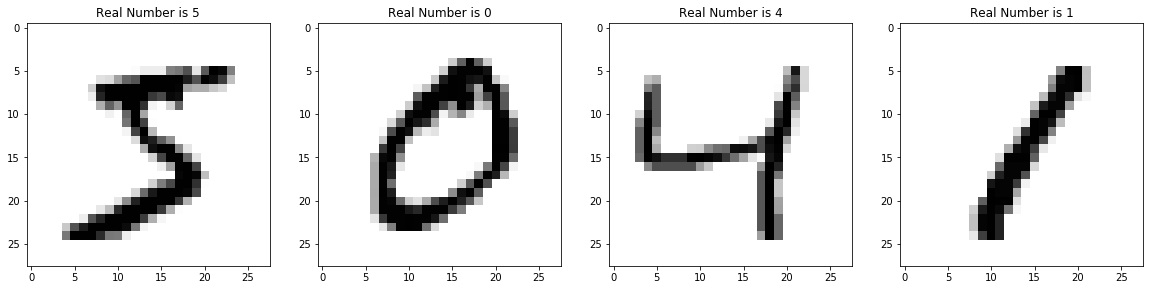

In [9]:
# Actual Images

fig , axis = plt.subplots(1,4,figsize = (20,10))

for i, ax in enumerate(axis.flat):
    ax.imshow(x_train[i].reshape(28,28),cmap="binary")
    digit = y[i].argmax()
    ax.set(title = f"Real Number is {digit}")

In [11]:
# Creating Images with Gaussian Noise

noised = []
noised_test = []

# Training Data
for i in range(0,x_train.shape[0]):
    noise = gaussian_noise(x_train[i].reshape(28,28),60)
    noised.append(np.array(noise))

# Validation Data
for i in range(0,x_test.shape[0]):
    noise = gaussian_noise(x_test[i].reshape(28,28),60)
    noised_test.append(np.array(noise))
    
noised = np.array(noised)
noised_test = np.array(noised_test)

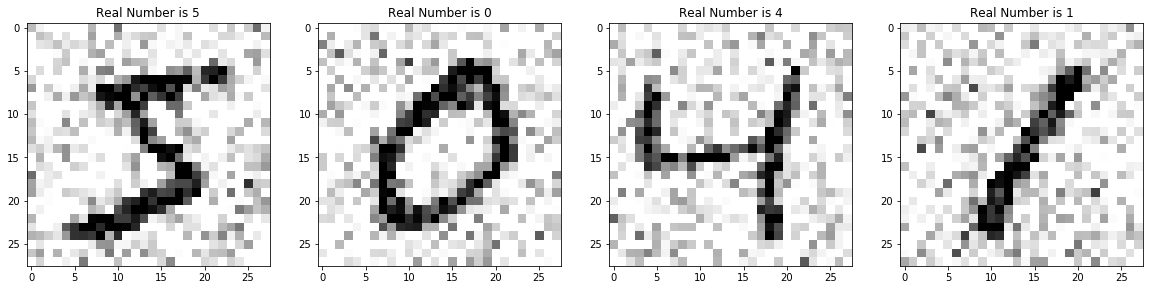

In [12]:
# Images after addition of Gaussian Noise

fig , axis = plt.subplots(1,4,figsize = (20,10))

for i, ax in enumerate(axis.flat):
    ax.imshow(noised[i].reshape(28,28),cmap="binary")
    digit = y[i].argmax()
    ax.set(title = f"Real Number is {digit}")

In [14]:
# Reshaping data in 3 dimension image (grayscale) for CNN (28,28,1) to understand

x_train = x_train.reshape(-1,28,28,1)
noised = noised.reshape(-1,28,28,1)

noised_test = noised_test.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

In [15]:
print(x_train.shape)
print(noised.shape)
print(noised_test.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(60000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)


In [16]:
# Normalizing Data
x_train = x_train/255.0
noised = noised/255.0

noised_test = noised_test/255.0
x_test = x_test/255.0

In [17]:
##############
# Autoencoder
##############

input_img = Input(shape=(28, 28, 1))  

# Encoder

# Conv1 #
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

# Conv2 #
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)


# Decoder

# DeConv1
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

# DeConv2
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [18]:
# Declare the model

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
# Declaring Callbacks

reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss',
                                       factor=0.1,
                                       patience=5,
                                       min_lr=0.0000000002,
                                       verbose=1)

early = callbacks.EarlyStopping(monitor='val_accuracy',
                               min_delta=0.00001,
                               patience=50,
                               verbose=1,
                               restore_best_weights = True,
                               mode='max')

In [20]:
# Defining epochs and batch_size
epochs = 1000
batch_size = 128

In [21]:
# Autoencoder Summary

autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 32)        0   

In [22]:
history_autoencoder = autoencoder.fit(noised, x_train,
                        batch_size=batch_size,
                        epochs=epochs, 
                        callbacks=[reduce_lr,early],
                        shuffle=True,
                        validation_split=0.05
                        )

Train on 57000 samples, validate on 3000 samples
Epoch 1/1000
57000/57000 [==============================] - 230s 4ms/step - loss: 0.1433 - accuracy: 0.8087 - val_loss: 0.1012 - val_accuracy: 0.8115
Epoch 2/1000
57000/57000 [==============================] - 228s 4ms/step - loss: 0.0917 - accuracy: 0.8138 - val_loss: 0.0897 - val_accuracy: 0.8136
Epoch 3/1000
57000/57000 [==============================] - 227s 4ms/step - loss: 0.0863 - accuracy: 0.8144 - val_loss: 0.0870 - val_accuracy: 0.8139
Epoch 4/1000
57000/57000 [==============================] - 226s 4ms/step - loss: 0.0835 - accuracy: 0.8147 - val_loss: 0.0869 - val_accuracy: 0.8140
Epoch 5/1000
57000/57000 [==============================] - 226s 4ms/step - loss: 0.0817 - accuracy: 0.8148 - val_loss: 0.0836 - val_accuracy: 0.8144
Epoch 6/1000
57000/57000 [==============================] - 226s 4ms/step - loss: 0.0805 - accuracy: 0.8149 - val_loss: 0.0828 - val_accuracy: 0.8145
Epoch 7/1000
57000/57000 [=========================

57000/57000 [==============================] - 174s 3ms/step - loss: 0.0732 - accuracy: 0.8154 - val_loss: 0.0748 - val_accuracy: 0.8152
Epoch 55/1000
57000/57000 [==============================] - 173s 3ms/step - loss: 0.0732 - accuracy: 0.8154 - val_loss: 0.0748 - val_accuracy: 0.8152
Epoch 56/1000
57000/57000 [==============================] - 173s 3ms/step - loss: 0.0732 - accuracy: 0.8154 - val_loss: 0.0748 - val_accuracy: 0.8152
Epoch 57/1000
57000/57000 [==============================] - 175s 3ms/step - loss: 0.0732 - accuracy: 0.8154 - val_loss: 0.0748 - val_accuracy: 0.8152
Epoch 58/1000
57000/57000 [==============================] - 176s 3ms/step - loss: 0.0732 - accuracy: 0.8154 - val_loss: 0.0748 - val_accuracy: 0.8152
Epoch 59/1000
57000/57000 [==============================] - 174s 3ms/step - loss: 0.0731 - accuracy: 0.8154 - val_loss: 0.0748 - val_accuracy: 0.8152

Epoch 00059: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
Epoch 60/1000
57000/57000 [=

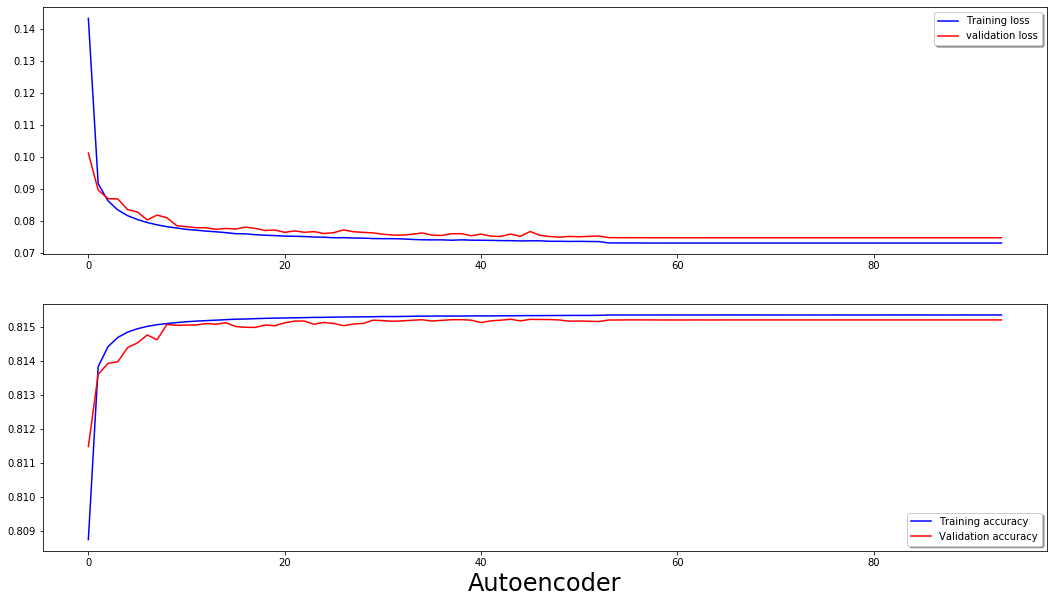

In [69]:
# Plotting Training and Validation Loss

fig, ax = plt.subplots(2,1, figsize=(18, 10))

ax[0].plot(history_autoencoder.history['loss'], color='b', label="Training loss")
ax[0].plot(history_autoencoder.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

# Plotting Training and Validation Accuracy

ax[1].plot(history_autoencoder.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history_autoencoder.history['val_accuracy'], color='r',label="Validation accuracy")
ax[1].set_xlabel("Autoencoder",fontsize=24)
legend = ax[1].legend(loc='best', shadow=True)

In [26]:
# Denoiseing Images

decoded_imgs = autoencoder.predict(noised_test)

Actual Image


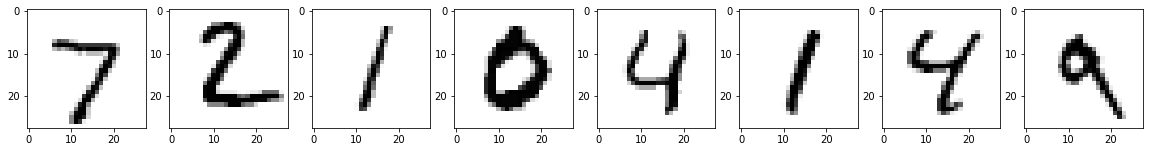

Image with added Noise


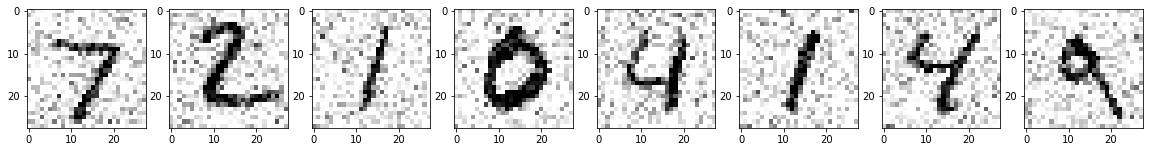

Decoded image


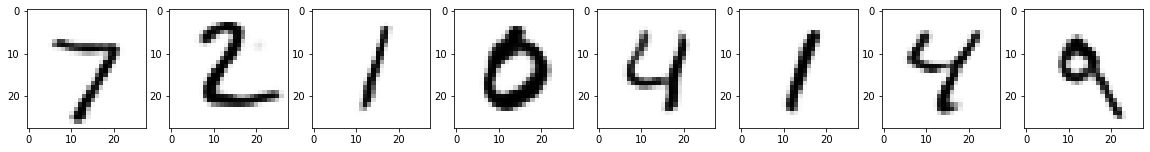

In [33]:
# Results

fig , axis = plt.subplots(1,8,figsize = (20,10))

print("Actual Image")
for i, ax in enumerate(axis.flat):
    ax.imshow(x_test[i].reshape(28, 28),cmap="binary")
plt.show()

fig , axis = plt.subplots(1,8,figsize = (20,10))

print("Image with added Noise")
for i, ax in enumerate(axis.flat):
    ax.imshow(noised_test[i].reshape(28, 28),cmap="binary")
plt.show()

fig , axis = plt.subplots(1,8,figsize = (20,10))

print("Decoded image")
for i, ax in enumerate(axis.flat):
    ax.imshow(decoded_imgs[i].reshape(28, 28),cmap="binary")

plt.show()

In [34]:
# Creating classifer on top of auto-encoder

#Adding Convolution Layer 
new = Conv2D(4,(3,3),activation='relu',padding='valid')(decoded)
new = Conv2D(4,kernel_size=(3,3),activation='relu',padding='valid')(new)
new = Conv2D(5,kernel_size=(3,3),activation='relu',padding='valid')(new)

#Pooling Features
new = AveragePooling2D((3,3),strides=(2,2),padding='valid')(new)

#Flatting of Images
new = Flatten()(new)

#Dense Layer
new = Dense(15,activation='relu')(new)

#Output Layer
new = Dropout(0.1)(new)
new = Dense(10,activation='softmax')(new)

In [35]:
# Declare the model
classifier = Model(input_img, new)

#Compiling Model
classifier.compile(optimizer='nadam',loss='categorical_crossentropy',metrics=['accuracy'])

In [30]:
# Training only newly added FCL

for model in classifier.layers[:-8]:
    model.trainable = False

In [36]:
# Classifier Summary

classifier.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 32)        0   

In [37]:
history_classifier = classifier.fit(noised, y,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    validation_split=0.05,
                                    callbacks=[reduce_lr,early],
                                    shuffle=True)

Train on 57000 samples, validate on 3000 samples
Epoch 1/1000
57000/57000 [==============================] - 50s 885us/step - loss: 0.5548 - accuracy: 0.8214 - val_loss: 0.1595 - val_accuracy: 0.9577
Epoch 2/1000
57000/57000 [==============================] - 53s 931us/step - loss: 0.2484 - accuracy: 0.9235 - val_loss: 0.1339 - val_accuracy: 0.9627
Epoch 3/1000
57000/57000 [==============================] - 57s 1ms/step - loss: 0.2044 - accuracy: 0.9367 - val_loss: 0.1172 - val_accuracy: 0.9693
Epoch 4/1000
57000/57000 [==============================] - 57s 1ms/step - loss: 0.1802 - accuracy: 0.9454 - val_loss: 0.1056 - val_accuracy: 0.9700
Epoch 5/1000
57000/57000 [==============================] - 59s 1ms/step - loss: 0.1684 - accuracy: 0.9480 - val_loss: 0.0959 - val_accuracy: 0.9743
Epoch 6/1000
57000/57000 [==============================] - 58s 1ms/step - loss: 0.1561 - accuracy: 0.9521 - val_loss: 0.0902 - val_accuracy: 0.9770
Epoch 7/1000
57000/57000 [===========================

57000/57000 [==============================] - 86s 2ms/step - loss: 0.0607 - accuracy: 0.9802 - val_loss: 0.0595 - val_accuracy: 0.9890
Epoch 55/1000
57000/57000 [==============================] - 87s 2ms/step - loss: 0.0592 - accuracy: 0.9808 - val_loss: 0.0602 - val_accuracy: 0.9870
Epoch 56/1000
57000/57000 [==============================] - 87s 2ms/step - loss: 0.0582 - accuracy: 0.9810 - val_loss: 0.0641 - val_accuracy: 0.9863
Epoch 57/1000
57000/57000 [==============================] - 87s 2ms/step - loss: 0.0585 - accuracy: 0.9811 - val_loss: 0.0548 - val_accuracy: 0.9890

Epoch 00057: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 58/1000
57000/57000 [==============================] - 88s 2ms/step - loss: 0.0498 - accuracy: 0.9838 - val_loss: 0.0563 - val_accuracy: 0.9883
Epoch 59/1000
57000/57000 [==============================] - 86s 2ms/step - loss: 0.0456 - accuracy: 0.9851 - val_loss: 0.0564 - val_accuracy: 0.9883
Epoch 60/1000
57000/57000 [=====

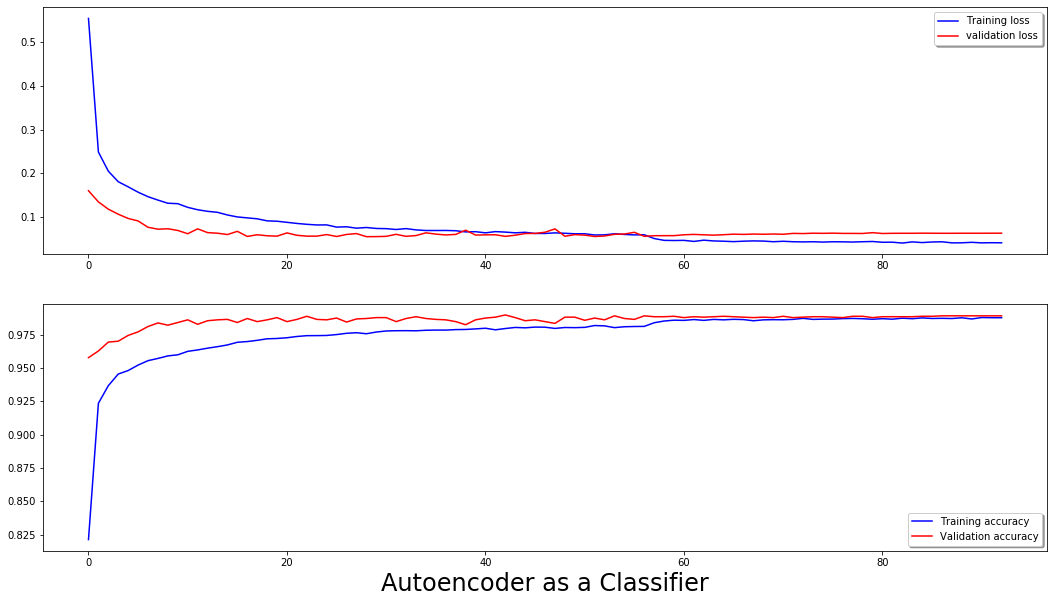

In [70]:
# Plotting Training and Validation Loss

fig, ax = plt.subplots(2,1, figsize=(18, 10))

ax[0].plot(history_classifier.history['loss'], color='b', label="Training loss")
ax[0].plot(history_classifier.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

# Plotting Training and Validation Accuracy

ax[1].plot(history_classifier.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history_classifier.history['val_accuracy'], color='r',label="Validation accuracy")
ax[1].set_xlabel("Autoencoder as a Classifier",fontsize=24)
legend = ax[1].legend(loc='best', shadow=True)

In [40]:
# Predicting result

# Predict encoded label as 2 => [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
predictions = classifier.predict(noised_test)

# Decode Predicted labels
Y_pred = np.argmax(predictions, 1) 

Actual Image


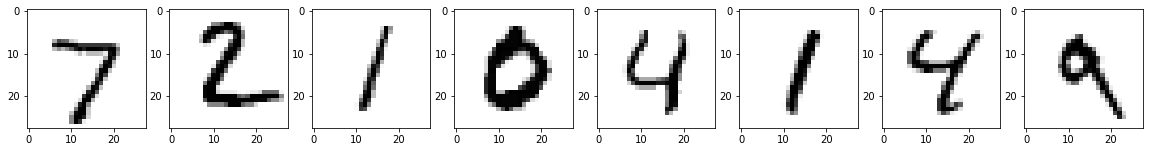

Image with added Noise


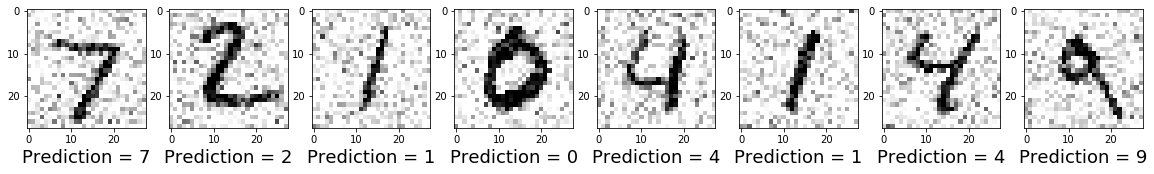

In [51]:
# Results

fig , axis = plt.subplots(1,8,figsize = (20,10))

print("Actual Image")
for i, ax in enumerate(axis.flat):
    ax.imshow(x_test[i].reshape(28, 28),cmap="binary")
plt.show()

fig , axis = plt.subplots(1,8,figsize = (20,10))

print("Image with added Noise")
for i, ax in enumerate(axis.flat):
    ax.imshow(noised_test[i].reshape(28, 28),cmap="binary")
    ax.set_xlabel("Prediction = {}".format(Y_pred[i]),fontsize=18)
plt.show()


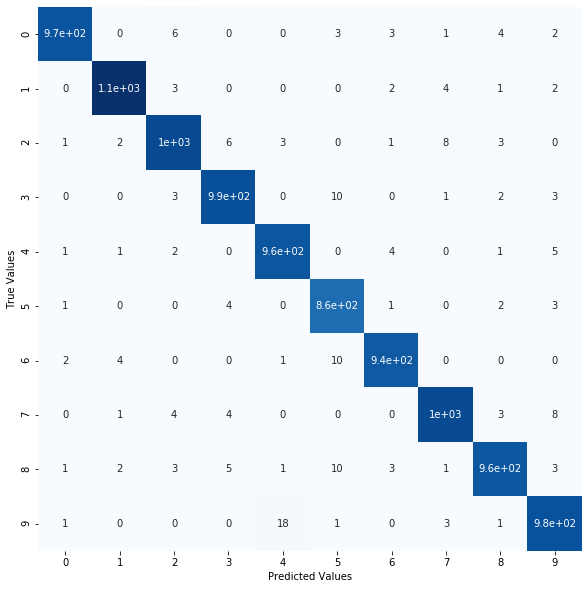

In [52]:
# Set Figure
fig = plt.figure(figsize=(10, 10)) 


Y_test = np.argmax(y_test, 1) # Decode labels

mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

In [55]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.98      0.98       982
           5       0.99      0.96      0.97       892
           6       0.98      0.99      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.98      0.98       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [65]:
print('Max Validation Accuracy =',max(history_classifier.history['val_accuracy'])*100,'%')
print('Max Training Accuracy =',max(history_classifier.history['accuracy'])*100,'% ')

Max Validation Accuracy = 98.96666407585144 %
Max Training Accuracy = 98.77368211746216 % 


In [57]:
autoencoder.save('autoencoder.h5')
classifier.save('classifier.h5')